#### Preparation
This notebook is only configured to use Weights & Biases for tracking metrics. Enabling this requires an account and api key, which can be set below. Unfortunately, the code below is not configured in such a way that it can easily be omitted. Feel free to remove this integration, though.  

Weights & Biases can be installed using: `pip install wandb`.  

This notebook requires the execution of:
- `Data Exporation and Preprocessing` 

In [1]:
import os
# Optional: set your W&B api key below. Looks like: 7ol65g3j2rulhg3af4o7m8wma8d9isyu3myqkdb8 (example)
os.environ['WANDB_API_KEY'] = ''
os.environ['WANDB_PROJECT'] = 'particle_process_discriminator'

if os.environ['WANDB_API_KEY'] is not '':
    # login to W&B account
    res = os.system('wandb login {}'.format(os.environ['WANDB_API_KEY']))
    print("Logged in to Weights & Biases")

#### Initialize

In [0]:
# For Google Colab:
%tensorflow_version 2.x

# (basic) dependencies
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm as tqdm

# sklearn dependencies
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, KFold

# tensorflow dependencies
from tensorflow.keras import datasets, layers, models, regularizers, backend
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding

import wandb
from wandb.keras import WandbCallback
MODEL_DIR = 'models'

In [0]:
# own dependencies
from helper import metrics, learn, select_features, load_data, cross_validation, ROC
from helper import make, save, make_args, build_architecture, train_net, train_args

In [0]:
# further settings
FIG_DIR = 'figures/'
plt.rcParams["figure.figsize"] = (10, 4.5)
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["savefig.transparent"] = True
plt.rcParams.update({'font.size': 14})
plt.rcParams["savefig.bbox"] = 'tight'

random_state = 576

In [0]:
def plot_accuracy_gain(acc, labels, baseline, fn):
    f, axes = plt.subplots(1, 1, figsize=(10, 5))
    ax = axes

    # calculate means and std. between trails
    try:
        means, stds = np.mean(acc, axis=-1), np.std(acc, axis=-1)
    except:
        assert isinstance(acc, list), "Need ndarray or list"
        means, stds = [], []
        for acc_row in acc:
            means.append(np.mean(acc_row))
            stds.append(np.std(acc_row))
        means, stds = np.array(means), np.array(stds)

    # plot bar plot with height the mean and error bars the deviation
    # substract a baseline from all means
    ax.bar(range(len(labels)), height=means - means[baseline], yerr=stds, capsize=4)
    ax.axhline(0, color='k')
    ax.set_xticklabels(labels)
    ax.set_xticks(range(len(labels)))

    # Set yticks to percentage
    vals = ax.get_yticks()
    # calculate the number of decimals to show without losing information
    num_decimals = max(0, int(np.ceil(np.mean(np.abs(np.log10(np.diff(vals)))) - 2)))
    labels = ['{x:,.{num}%}'.format(x=x, num=num_decimals) for x in vals]
    ax.set_yticklabels(labels)
    ax.set_ylabel("Validation accuracy gain")

    # Hide the right and top spines
    for loc in ['right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

    f.tight_layout()
    f.savefig('{}/{fn}'.format(FIG_DIR, fn=fn))
    plt.show()

def plot_history(history, limits=False):
    f, axes = plt.subplots(1, 1, figsize=(15, 8))
    ax = axes
    ax.plot(history.history['acc'], label='Train')

    # plot validation accuracy and maximal validation accuracy
    val_accs = history.history['val_acc']
    ax.plot(val_accs, label='Test')
    ax.plot(np.argmax(val_accs), np.max(val_accs), 'x', ms=15, color='r')
    ax.set_title("Accuracy (max. val. acc.: {:.2%})".format(np.max(val_accs))); 
    ax.set_ylabel("Accuracy"); ax.set_xlabel("Epoch"); ax.legend();
    if limits:
        ax.set_ylim(bottom=0.833, top=1)
    plt.show()

In [0]:
from tensorflow.keras.layers import LeakyReLU

class Args(pd.Series):
    def __init__(self, default_args={}, verbose=True, wandb_init=True):
        """Create default arguments, which can be changed for subsequent runs"""
        # construct Series object
        super(Args, self).__init__()
        # set defaults, with absolute defaults set first
        self.set_args(default_args, reset=True, verbose=verbose, wandb_init=wandb_init)
    
    def set_args(self, new_args, reset=False, verbose=True, wandb_init=True):
        if reset:
            # fill arguments with absolute defaults
            defaults = {
                'id': 'Baseline',
                'architecture': 'small net',
                'loss': 'binary_crossentropy', 
                'activation': LeakyReLU(alpha=0.3),
                'final_activation': 'sigmoid',
                'epochs': 100, 
                'batch_size': 256,
                'optimizer': 'adam', 
                'lr': 1e-4, 
                'lr_decay': 0,
                'norm': 'zscore', 
                'trans': 'both',
                'nodes1': 128, 'nodes2': 64, 'nodes3': 32, 
                'nodes4': 0, 'nodes5': 0,
                'dropout1': 0.15, 'dropout2': 0.15, 'dropout3': 0.15, 
                'dropout4': 0.15, 'dropout5': 0.15,
                'batch_norm': [], 
            }
            # set defaults
            for k, val in defaults.items():
                self[k] = val
        
        # set new arguments
        for k, val in new_args.items():
            self[k] = val

        if verbose:
            print(self)
        
        if wandb_init:
            wandb.init(project=os.environ['WANDB_PROJECT'], name=self.id, config=dict(self))


In [0]:
def save_metrics(cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies, name):
    np.save("results/{}_cv_train_accuracies".format(name), cv_train_accuracies)
    np.save("results/{}_cv_val_accuracies".format(name), cv_val_accuracies)
    np.save("results/{}_cv_max_val_accuracies".format(name), cv_max_val_accuracies)

def load_metrics(name):
    cv_train_accuracies = np.load("results/{}_cv_train_accuracies.npy".format(name))
    cv_val_accuracies = np.load("results/{}_cv_val_accuracies.npy".format(name))
    cv_max_val_accuracies = np.load("results/{}_cv_max_val_accuracies.npy".format(name))
    return cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies, 

# Particle Process Discriminator - Train Deep Neural Networks

This notebook will optimize the deep neural networks and will explore the symmetries in the tabular data set. 

## Implement data augmentation on tabular dataset
The batch creator below implements rotational symmetry of the whole system about the beam axis ("phi augmentation"), by adding a constant to all phi-features. Because of the cyclical nature of the azimuthal angle, the modulus is taken to reflect this in the tabular dataset.  

Also, the batch creator implements data augmentation of an inversion in the particle collision centre, which corresponds to "mirroring" the pseudorapidity. 

In [0]:
class BatchCreator2:
    def __init__(self, dataset, features, target, balance_classes=False, 
                 shift_phi=False, flip_eta=False, batch_size=64):
        # save dataset as features and targets
        self.x = dataset[features].values.astype(float)
        self.y = dataset[target].values.astype(float)

        # calculate n.o. samples and save settings
        self.n = len(self.y)
        self.n_classes = len(features)
        self.balance_classes = balance_classes
        self.shift_phi = shift_phi
        self.flip_eta = flip_eta
        self.batch_size = batch_size

        # create mask for phi columns
        phi_cols = dataset.filter(regex='phi').columns
        self.phi_col_mask = [col in phi_cols for col in features]
        self.phi_mask = np.hstack(self.phi_col_mask * batch_size).reshape(batch_size, self.n_classes)
        eta_cols = dataset.filter(regex='eta').columns
        self.eta_col_mask = [col in eta_cols for col in features]
        self.eta_mask = np.hstack(self.eta_col_mask * batch_size).reshape(batch_size, self.n_classes)

        # calculate samplewise probabilities
        if balance_classes:
            # calculate probabilities for each class
            p_class = dataset[target].value_counts()
            self.p_sample = np.zeros(self.n)
            # set samplewise probability to the inverse frequency of its class
            for val, count in p_class.iteritems():
                # and normalise by the number of classes, such that all probabilities sum up to one
                self.p_sample[dataset[target].values == val] = 1/count/p_class.index.size
        else:
            self.p_sample = np.ones(self.n) / self.n
        
        # calculate range for augmenting phi angles
        self.cmin = dataset[phi_cols].min().min()
        self.cmax = dataset[phi_cols].max().max()
        self.crange = self.cmax - self.cmin


    def create_batch(self, batch_size):
        '''
        returns an array of features (x) with corresponding labels (y)
        '''
        x_data = np.zeros((batch_size, self.n_classes))
        y_data = np.zeros((batch_size, 1))
        indices = np.random.choice(np.arange(self.n), size=batch_size, replace=False, p=self.p_sample)
        
        """ Method below works, but is (too) slow. Creating the batches on 
        batch level reduces training time from about 10 minutes to about 20 seconds/epoch. 
        For reference, without augmentation the training time took about 9 seconds/epoch. 

        # select and augment the designated samples
        for i, idx in enumerate(indices):
            # augment the phi angles by adding a constant and cyclically take the modulus
            c = np.random.random_sample() * self.crange

            # exclude phi columns which are zero (from padding)
            mask = (self.df[self.phi_cols].iloc[idx] != 0)
            augment_cols = mask[mask].index

            sample_features = self.df[self.features].iloc[idx]
            # -cmin and +cmin for shifting range [cmin, cmax] for modulus
            sample_features[augment_cols] = (sample_features[augment_cols] + c - self.cmin) % self.crange + self.cmin

            x_data[i] = sample_features.values
            y_data[i] = self.df[target].iloc[idx].astype(float)
        """
        # select batch features
        batch_features = self.x[indices]

        # cyclically shift azimuthal angles
        if self.shift_phi:
            # exclude phi columns which are zero (from padding)
            nonzero_mask = (batch_features != 0)
            aug_mask = (nonzero_mask & self.phi_mask)

            # perform steps above at batch level 
            # NOTE: ADDS SAME CONSTANT TO WHOLE BATCH!
            c = np.random.rand() * self.crange

            batch_features[aug_mask] = (batch_features[aug_mask] + c - self.cmin) % self.crange + self.cmin

        # mirror pseudorapidity in pi/2 axis, for 50% of batches
        if self.flip_eta and np.random.choice([True, False]):
            # exclude eta columns which are zero (from padding)
            nonzero_mask = (batch_features != 0)
            aug_mask = (nonzero_mask & self.eta_mask)

            # perform flipping eta at batch level 
            # NOTE: FLIPS ALL OR NONE OF THE SAMPLES IN THE BATCH!
            batch_features[aug_mask] *= -1

        # return batch of features and labels    
        return batch_features, self.y[indices]
        
    def flow(self):
        '''returns a generator that will yield batches infinitely'''
        while True:
            yield self.create_batch(self.batch_size)

# Hyperparameter optimisation
**Initial phase**  
The baseline start in a reasonable, but definitely not optimal, starting point. This starting point is chosen to highly overfit the training data, and work from there to a good validation convergence. The first steps include data augmentation into training the model. Then the generalization error is further reduced by adding dropout layers and, based on the results obtained there, reduce the number of layers and/or width of the model. 

For these steps 5-fold cross-validation is done, without setting aside a 'test' set. Both the maximal validation accuracies and final epoch accuracies are collected.  

Each test incorporates the best configuration of the preceding tests.  

**Second phase**  
After the tests of the initial phase, we should have a model with a reasonable accuracy and generalization error. At this point, the model will be optimised by investigating:
- transformation of the features with long tail
- nonlinearity
- optimizer
- batch size

**Results**  
For the results, see the individual results below, and the reports per test here:  
- dropout: https://app.wandb.ai/joeranbosma/ml4ppa/reports/
- n.o. layers: https://app.wandb.ai/joeranbosma/ml4ppa/reports/Depth--Vmlldzo3MDgxMA/
- transformation: https://app.wandb.ai/joeranbosma/ml4ppa/reports/Transformation--Vmlldzo3MDg3NA/
- nonlinearity: https://app.wandb.ai/joeranbosma/ml4ppa/reports/Activation-function--Vmlldzo3MDg4MQ/
- optimiser: https://app.wandb.ai/joeranbosma/ml4ppa/reports/Optimiser--Vmlldzo3MTE5Mw/
- batch size: https://app.wandb.ai/joeranbosma/ml4ppa/reports/Batch-size--Vmlldzo3MTI1Nw/

## Test 0: capacity of model
Check if the model is capable of overfitting the dataset to near perfection. This tests the capacity of the model and check, for example, if the learning rate is not too low.  

- 64x64x64 reaches a train accuracy of 0.9475 in 100 epochs
- 128x128x128x128x128 reaches a train accuracy of 0.9971 in 100 epochs

In [20]:
args = Args({'id': 'MLP - capacity', 'architecture': '128^5', 'norm': 'minmax', 'trans': 'plain',
             'nodes1': 128, 'nodes2': 128, 'nodes3': 128, 'nodes4': 128, 'nodes5': 128,
             'dropout1': 0, 'dropout2': 0, 'dropout3': 0, 'dropout4': 0, 'dropout5': 0,
             'activation': 'relu', 'batch_size': 64,
             'shift_phi': False, 'flip_eta': False}, verbose=True, wandb_init=True)

# read train and validation data
train_df, val_df, features, target = load_data('data', trans=args.trans, norm=args.norm)

model = build_architecture(args, input_shape=(len(features),))
train_batch_generator = BatchCreator2(train_df, features, target, balance_classes=False,
                                      shift_phi=args.shift_phi, flip_eta=args.flip_eta,
                                      batch_size=args.batch_size)

# train the model
history = model.fit(train_batch_generator.flow(), 
                    steps_per_epoch = train_batch_generator.n // train_batch_generator.batch_size,
                    validation_data=(val_df[features].values, val_df[target].values),
                    epochs=args.epochs, verbose=1, callbacks=[WandbCallback()])

id                       MLP - capacity
architecture                      128^5
loss                binary_crossentropy
activation                         relu
final_activation                sigmoid
epochs                              100
batch_size                           64
optimizer                          adam
lr                               0.0001
lr_decay                              0
norm                             minmax
trans                             plain
nodes1                              128
nodes2                              128
nodes3                              128
nodes4                              128
nodes5                              128
dropout1                              0
dropout2                              0
dropout3                              0
dropout4                              0
dropout5                              0
batch_norm                           []
shift_phi                         False
flip_eta                          False


Epoch 1/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2644 - acc: 0.8964 - val_loss: 0.1746 - val_acc: 0.9286
Epoch 2/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1675 - acc: 0.9324 - val_loss: 0.1675 - val_acc: 0.9320
Epoch 3/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1591 - acc: 0.9347 - val_loss: 0.1698 - val_acc: 0.9320
Epoch 4/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1545 - acc: 0.9378 - val_loss: 0.1637 - val_acc: 0.9328
Epoch 5/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1504 - acc: 0.9385 - val_loss: 0.1657 - val_acc: 0.9330
Epoch 6/100
1250/1250 [==============================] - 6s 4ms/step - loss: 0.1469 - acc: 0.9406 - val_loss: 0.1623 - val_acc: 0.9339
Epoch 7/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1450 - acc: 0.9400 - val_loss: 0.1609 - val_acc: 0.9323
Epoch 8/100
1250/1250 [==============================] 

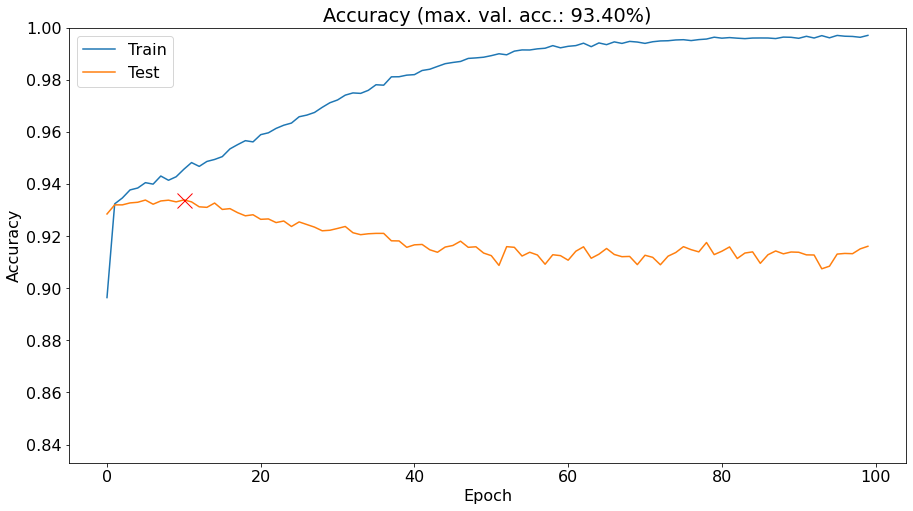

In [23]:
plot_history(history, limits=True)

## Cross-validation setup with generator

In [0]:
def train_net_gen(args, train_iterator, val_features, val_labels, model=None, keras_verbose=0, 
                  verbose=True, evaluate=True, prediction_threshold='infer'):

    # Set up the model, if not provided
    if model == None:
        model = build_architecture(args, input_shape=(train_iterator.n_classes,))
    
    if verbose:
        model.summary()
    
    callbacks = []
    if args.lr_decay > 0:
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=args.lr_decay,
                              patience=7, min_lr=1e-6)
        callbacks.append(reduce_lr)
    
    if 'callbacks' in args.keys():
        callbacks.extend(args.callbacks)
    callbacks.append(WandbCallback())

    # train the model
    history = model.fit(train_iterator.flow(),
                        steps_per_epoch = train_iterator.n // train_iterator.batch_size,
                        validation_data=(val_features, val_labels), 
                        epochs=args.epochs, verbose=keras_verbose, callbacks=callbacks)
    
    # save model online
    model.save(os.path.join(wandb.run.dir, "model-final.h5"))

    if evaluate:
        # evaluate model performance
        # if prediction threshold needs to be inferred, try different values for
        # the training set and use the optimal value for the validation predictions
        if prediction_threshold == 'infer':
            print("Inferring optimal prediction threshold..")
            accs = [] 
            # skip unlikely values <0.2 and >0.8
            search_space = np.linspace(0.2, 0.8, num=31)
            for threshold in tqdm(search_space):
                # calculate predictions for the validation data
                ypred = model.predict(train_features)
                pred = (ypred > threshold)

                # calculate (and show) metrics
                conf_mat, accuracy = metrics(train_labels, pred, verbose=False)
                accs.append(accuracy)
            # select optimal value for train set as threshold
            prediction_threshold = search_space[np.argmax(accs)]
            if verbose:
                print("Optimal threshold: {}".format(prediction_threshold))

        # calculate predictions for the validation data
        ypred = model.predict(validation[features])
        pred = (ypred > prediction_threshold)

        # calculate (and show) metrics
        conf_mat, accuracy = metrics(validation[target], pred, verbose=True)

    return model, history

In [0]:
def aug_cv_test(args, cv_splits=5, split_test_set=False, random_state=576, 
                return_histories=False, return_models=False, return_test_set=False,
                verbose=True, wandb_init=True):
    # read train and validation data
    train_df, val_df, features, target = load_data('data', trans=args.trans, norm=args.norm)
    
    # combine train and validation data (for we will perform our own splits)
    data_df = train_df.append(val_df, ignore_index=True)

    if split_test_set:
        # select test set
        kf = KFold(n_splits=cv_splits+1, shuffle=True, random_state=random_state)
        train_val_indices, test_indices = next(kf.split(data_df))

        # redefine train&validation and test sets
        data_df, test_df = data_df.iloc[train_val_indices], data_df.iloc[test_indices]
    
    print("Performing {}-fold cross validation with {} samples".format(
        cv_splits, data_df.index.size))
    
    cv_train_accuracies = []
    cv_val_accuracies = []
    cv_max_val_accuracies = []
    cv_histories = []
    cv_models = []
    for cv_it in range(1, 1+cv_splits):
        # employ cross validation splits
        kf = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
        # bit wacky, but this selects the cv-th set of train/test indices (with cv starting at ONE)
        for i in range(cv_it):
            train_indices, val_indices = next(kf.split(data_df))
        
        # (re)define train and validation sets
        train_df, val_df = data_df.iloc[train_indices], data_df.iloc[val_indices]
        print("Starting fold {}/{} with {} train samples and {} validation samples".format(
            cv_it, cv_splits, len(train_indices), len(val_indices)
        ))
        
        # save cross-validation settings to arguments, and as a result to W&B
        args['cv_splits'] = cv_splits
        args['cv_iteration'] = cv_it

        # start Weights & Biases run
        if wandb_init:
            wandb.init(project='ml4ppa', name=args.id, config=dict(args))

        # get generators
        train_batch_generator = BatchCreator2(train_df, features, target, balance_classes=False,
                                              shift_phi=args.shift_phi, flip_eta=args.flip_eta,
                                              batch_size=args.batch_size)
        
        # train and evaluate model
        model, history = train_net_gen(args, train_batch_generator, val_df[features].values, val_df[target].values, 
                                       keras_verbose=0, verbose=False, evaluate=False)
        
        # save results
        cv_models.append(model)
        cv_histories.append(history)
        cv_train_accuracies.append(history.history['acc'][-1])
        cv_val_accuracies.append(history.history['val_acc'][-1])
        cv_max_val_accuracies.append(np.max(history.history['val_acc']))

    if verbose:
        train_mean, train_std = np.mean(cv_train_accuracies), np.std(cv_train_accuracies)
        val_mean, val_std = np.mean(cv_val_accuracies), np.std(cv_val_accuracies)
        print("{} train acc: {:.5f}±{:.5f}, val acc: {:.5f}±{:.5f}".format(
            args.id, train_mean, train_std, val_mean, val_std))
    
    # accumulate returns
    returns = [cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies]
    if return_histories:
        returns.append(cv_histories)
    if return_models:
        returns.append(cv_models)
    if return_test_set:
        returns.append(test_df)
    
    return returns

## Test 1: Baseline

In [24]:
args = Args({'id': 'MLP - baseline', 'architecture': '128^5', 'norm': 'minmax', 'trans': 'plain',
             'nodes1': 128, 'nodes2': 128, 'nodes3': 128, 'nodes4': 128, 'nodes5': 128,
             'dropout1': 0, 'dropout2': 0, 'dropout3': 0, 'dropout4': 0, 'dropout5': 0,
             'activation': 'relu', 'batch_size': 64,
             'shift_phi': False, 'flip_eta': False}, verbose=True, wandb_init=False)

cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies = aug_cv_test(args)

id                       MLP - baseline
architecture                      128^5
loss                binary_crossentropy
activation                         relu
final_activation                sigmoid
epochs                              100
batch_size                           64
optimizer                          adam
lr                               0.0001
lr_decay                              0
norm                             minmax
trans                             plain
nodes1                              128
nodes2                              128
nodes3                              128
nodes4                              128
nodes5                              128
dropout1                              0
dropout2                              0
dropout3                              0
dropout4                              0
dropout5                              0
batch_norm                           []
shift_phi                         False
flip_eta                          False


Starting fold 2/5 with 80000 train samples and 20000 validation samples


Retry attempt failed:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse()
  File "/usr/lib/python3.6/http/client.py", line 1346, in getresponse
    response.begin()
  File "/usr/lib/python3.6/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/usr/lib/python3.6/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/usr/lib/python3.6/socket.py", line 586, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.6/ssl.py", line 1012, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.6/ssl.py", line 874, in read
    return self._sslobj.read(len, buffer)
  Fi

Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - baseline train acc: 0.99672±0.00045, val acc: 0.91422±0.00241


In [0]:
save_metrics(cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies, name="baseline")

## Test 2: data augmentation of phi angles
Investigate rotational symmetry of the system.

In [26]:
args = Args({'id': 'MLP - phi aug', 'architecture': '128^5', 'norm': 'minmax', 'trans': 'plain',
             'nodes1': 128, 'nodes2': 128, 'nodes3': 128, 'nodes4': 128, 'nodes5': 128,
             'dropout1': 0, 'dropout2': 0, 'dropout3': 0, 'dropout4': 0, 'dropout5': 0,
             'activation': 'relu', 'batch_size': 64,
             'shift_phi': True, 'flip_eta': False}, verbose=True, wandb_init=False)

cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies = aug_cv_test(args)
save_metrics(cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies, name="phi_aug")

id                        MLP - phi aug
architecture                      128^5
loss                binary_crossentropy
activation                         relu
final_activation                sigmoid
epochs                              100
batch_size                           64
optimizer                          adam
lr                               0.0001
lr_decay                              0
norm                             minmax
trans                             plain
nodes1                              128
nodes2                              128
nodes3                              128
nodes4                              128
nodes5                              128
dropout1                              0
dropout2                              0
dropout3                              0
dropout4                              0
dropout5                              0
batch_norm                           []
shift_phi                          True
flip_eta                          False


Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - phi aug train acc: 0.95237±0.00047, val acc: 0.93534±0.00138


**Result**: generalization error reduced significantly, validation accuracy increased.

## Test 3: data augmentation of eta angles
Investigate inversion data augmentation of pseudorapidities.

In [27]:
args = Args({'id': 'MLP - eta aug', 'architecture': '128^5', 'norm': 'minmax', 'trans': 'plain',
             'nodes1': 128, 'nodes2': 128, 'nodes3': 128, 'nodes4': 128, 'nodes5': 128,
             'dropout1': 0, 'dropout2': 0, 'dropout3': 0, 'dropout4': 0, 'dropout5': 0,
             'activation': 'relu',  'batch_size': 64,
             'shift_phi': True, 'flip_eta': True}, verbose=True, wandb_init=False)

cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies = aug_cv_test(args)
save_metrics(cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies, name="eta_aug")

id                        MLP - eta aug
architecture                      128^5
loss                binary_crossentropy
activation                         relu
final_activation                sigmoid
epochs                              100
batch_size                           64
optimizer                          adam
lr                               0.0001
lr_decay                              0
norm                             minmax
trans                             plain
nodes1                              128
nodes2                              128
nodes3                              128
nodes4                              128
nodes5                              128
dropout1                              0
dropout2                              0
dropout3                              0
dropout4                              0
dropout5                              0
batch_norm                           []
shift_phi                          True
flip_eta                           True


Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - eta aug train acc: 0.94528±0.00131, val acc: 0.93899±0.00054


In [28]:
print("Max. val. accuracies: {:.2%} ± {:.2%}".format(np.mean(cv_max_val_accuracies), np.std(cv_max_val_accuracies)))

Max. val. accuracies: 94.05% ± 0.02%


**Result**: generalization error reduced further, validation accuracy increased. In contrast to the runs of Test 1 and 2, training longer could actually further improve validation accuracy. 

## Test 4: dropout
Investigate dropout of 10%-20%-30%-40% after each dense layer. 

In [17]:
# current baseline options
args = Args({'id': 'MLP', 'architecture': '128^5', 'norm': 'minmax', 'trans': 'plain',
             'nodes1': 128, 'nodes2': 128, 'nodes3': 128, 'nodes4': 128, 'nodes5': 128,
             'dropout1': 0, 'dropout2': 0, 'dropout3': 0, 'dropout4': 0, 'dropout5': 0,
             'activation': 'relu',  'batch_size': 64,
             'shift_phi': True, 'flip_eta': True}, verbose=False, wandb_init=False)

# investigation options
dropout_options = np.arange(0.1, 0.4+0.00001, 0.1)

for i, drop_rate in enumerate(dropout_options):
    # set deviations from current baseline
    args.set_args({'id': 'MLP - dropout - {:.2f}'.format(drop_rate), 
                   'architecture': '128^5 + drop {:.2f}'.format(drop_rate),
                   'dropout1': drop_rate, 'dropout2': drop_rate, 'dropout3': drop_rate, 
                   'dropout4': drop_rate, 'dropout5': drop_rate},
                  verbose=True, wandb_init=False)

    cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies = aug_cv_test(args)
    save_metrics(cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies, 
                 name="drop_{:.2f}".format(drop_rate))
    print("Dropout {:.2f}, max. val. accuracies: {:.2%} ± {:.2%}".format(
        drop_rate, np.mean(cv_max_val_accuracies), np.std(cv_max_val_accuracies)))

id                  MLP - dropout - 0.10
architecture           128^5 + drop 0.10
loss                 binary_crossentropy
activation                          relu
final_activation                 sigmoid
epochs                               100
batch_size                            64
optimizer                           adam
lr                                0.0001
lr_decay                               0
norm                              minmax
trans                              plain
nodes1                               128
nodes2                               128
nodes3                               128
nodes4                               128
nodes5                               128
dropout1                             0.1
dropout2                             0.1
dropout3                             0.1
dropout4                             0.1
dropout5                             0.1
batch_norm                            []
shift_phi                           True
flip_eta        

Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - dropout - 0.10 train acc: 0.94410±0.00056, val acc: 0.93980±0.00044
Dropout 0.10, max. val. accuracies: 94.07% ± 0.04%
id                  MLP - dropout - 0.20
architecture           128^5 + drop 0.20
loss                 binary_crossentropy
activation                          relu
final_activation                 sigmoid
epochs                               100
batch_size                            64
optimizer                           adam
lr                                0.0001
lr_decay                               0
norm                              minmax
trans                              plain
nodes1                               128
nodes2                               128
nodes3                               128
nodes4                               128
nodes5                               128
dropout1                             0.2
dropout2                             0.2
dropout3                             0.2
dropout4                             0.2
dropout5      

Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - dropout - 0.20 train acc: 0.94491±0.00062, val acc: 0.93997±0.00048
Dropout 0.20, max. val. accuracies: 94.11% ± 0.04%
id                  MLP - dropout - 0.30
architecture           128^5 + drop 0.30
loss                 binary_crossentropy
activation                          relu
final_activation                 sigmoid
epochs                               100
batch_size                            64
optimizer                           adam
lr                                0.0001
lr_decay                               0
norm                              minmax
trans                              plain
nodes1                               128
nodes2                               128
nodes3                               128
nodes4                               128
nodes5                               128
dropout1                             0.3
dropout2                             0.3
dropout3                             0.3
dropout4                             0.3
dropout5      

Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - dropout - 0.30 train acc: 0.94351±0.00024, val acc: 0.93958±0.00044
Dropout 0.30, max. val. accuracies: 94.08% ± 0.04%
id                  MLP - dropout - 0.40
architecture           128^5 + drop 0.40
loss                 binary_crossentropy
activation                          relu
final_activation                 sigmoid
epochs                               100
batch_size                            64
optimizer                           adam
lr                                0.0001
lr_decay                               0
norm                              minmax
trans                              plain
nodes1                               128
nodes2                               128
nodes3                               128
nodes4                               128
nodes5                               128
dropout1                             0.4
dropout2                             0.4
dropout3                             0.4
dropout4                             0.4
dropout5      

Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - dropout - 0.40 train acc: 0.94232±0.00138, val acc: 0.93918±0.00114
Dropout 0.40, max. val. accuracies: 94.06% ± 0.04%


**Result**: Dropout performs best, with 94.11% ± 0.04% max. validation accuracy. A slight increase from the 94.05% ± 0.02% without dropout.

## Test 5: width

In [34]:
# current baseline options
args = Args({'id': 'MLP', 'architecture': '128^5 + drop 0.2', 'norm': 'minmax', 'trans': 'plain',
             'nodes1': 128, 'nodes2': 128, 'nodes3': 128, 'nodes4': 128, 'nodes5': 128,
             'dropout1': 0.2, 'dropout2': 0.2, 'dropout3': 0.2, 'dropout4': 0.2, 'dropout5': 0.2,
             'activation': 'relu',  'batch_size': 64,
             'shift_phi': True, 'flip_eta': True}, verbose=False, wandb_init=False)

# investigation options
width_options = [32, 64, 96]

for i, width in enumerate(width_options):
    # set deviations from current baseline
    args.set_args({'id': 'MLP - width - {}'.format(width), 
                   'architecture': '{}^5 + drop 0.2'.format(width),
                   'nodes1': width, 'nodes2': width, 'nodes3': width, 
                   'nodes4': width, 'nodes5': width},
                  verbose=True, wandb_init=False)

    cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies = aug_cv_test(args)
    save_metrics(cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies, 
                 name="width_{}".format(width))
    print("Width {}, max. val. accuracies: {:.2%} ± {:.2%}".format(
        width, np.mean(cv_max_val_accuracies), np.std(cv_max_val_accuracies)))

id                     MLP - width - 32
architecture            32^5 + drop 0.2
loss                binary_crossentropy
activation                         relu
final_activation                sigmoid
epochs                              100
batch_size                           64
optimizer                          adam
lr                               0.0001
lr_decay                              0
norm                             minmax
trans                             plain
nodes1                               32
nodes2                               32
nodes3                               32
nodes4                               32
nodes5                               32
dropout1                            0.2
dropout2                            0.2
dropout3                            0.2
dropout4                            0.2
dropout5                            0.2
batch_norm                           []
shift_phi                          True
flip_eta                           True


Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting fold 5/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


MLP - width - 32 train acc: 0.94105±0.00094, val acc: 0.93962±0.00071
Width 32, max. val. accuracies: 94.06% ± 0.04%
id                     MLP - width - 64
architecture            64^5 + drop 0.2
loss                binary_crossentropy
activation                         relu
final_activation                sigmoid
epochs                              100
batch_size                           64
optimizer                          adam
lr                               0.0001
lr_decay                              0
norm                             minmax
trans                             plain
nodes1                               64
nodes2                               64
nodes3                               64
nodes4                               64
nodes5                               64
dropout1                            0.2
dropout2                            0.2
dropout3                            0.2
dropout4                            0.2
dropout5                            0.2
bat

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting fold 2/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting fold 3/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting fold 4/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting fold 5/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


MLP - width - 64 train acc: 0.94273±0.00045, val acc: 0.93910±0.00066
Width 64, max. val. accuracies: 94.03% ± 0.04%
id                     MLP - width - 96
architecture            96^5 + drop 0.2
loss                binary_crossentropy
activation                         relu
final_activation                sigmoid
epochs                              100
batch_size                           64
optimizer                          adam
lr                               0.0001
lr_decay                              0
norm                             minmax
trans                             plain
nodes1                               96
nodes2                               96
nodes3                               96
nodes4                               96
nodes5                               96
dropout1                            0.2
dropout2                            0.2
dropout3                            0.2
dropout4                            0.2
dropout5                            0.2
bat

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting fold 2/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting fold 3/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting fold 4/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting fold 5/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Network error resolved after 0:00:18.155827, resuming normal operation.


MLP - width - 96 train acc: 0.94321±0.00119, val acc: 0.93967±0.00061
Width 96, max. val. accuracies: 94.09% ± 0.04%


Exception in thread Thread-554:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 81, in run
    self.prepare_file()
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 72, in prepare_file
    shutil.copy2(self.path, self.save_path)
  File "/usr/lib/python3.6/shutil.py", line 263, in copy2
    copyfile(src, dst, follow_symlinks=follow_symlinks)
  File "/usr/lib/python3.6/shutil.py", line 120, in copyfile
    with open(src, 'rb') as fsrc:
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpqgyeq27kwandb/batch-2.tgz'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 85, in run
    self.cleanup_file()
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 154, i

## Test 6: depth

In [35]:
# current baseline options
args = Args({'id': 'MLP', 'architecture': '128^5 + drop 0.2', 'norm': 'minmax', 'trans': 'plain',
             'nodes1': 128, 'nodes2': 128, 'nodes3': 128, 'nodes4': 128, 'nodes5': 128,
             'dropout1': 0.2, 'dropout2': 0.2, 'dropout3': 0.2, 'dropout4': 0.2, 'dropout5': 0.2,
             'activation': 'relu',  'batch_size': 64,
             'shift_phi': True, 'flip_eta': True}, verbose=False, wandb_init=False)

# investigation options
depth_options = [2, 3, 4]

for i, depth in enumerate(depth_options):
    # set deviations from current baseline
    nodes = 128
    args.set_args({'id': 'MLP - depth - {}'.format(depth), 
                   'architecture': '{}^{} + drop 0.2'.format(nodes, depth),
                   'nodes1': nodes, 'nodes2': nodes, 'nodes3': nodes if depth >= 3 else 0, 
                   'nodes4': nodes if depth >= 4 else 0, 'nodes5': 0},
                  verbose=True, wandb_init=False)

    cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies = aug_cv_test(args)
    save_metrics(cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies, 
                 name="depth_{}".format(depth))
    print("Depth {}, max. val. accuracies: {:.2%} ± {:.2%}".format(
        depth, np.mean(cv_max_val_accuracies), np.std(cv_max_val_accuracies)))

id                      MLP - depth - 2
architecture           128^2 + drop 0.2
loss                binary_crossentropy
activation                         relu
final_activation                sigmoid
epochs                              100
batch_size                           64
optimizer                          adam
lr                               0.0001
lr_decay                              0
norm                             minmax
trans                             plain
nodes1                              128
nodes2                              128
nodes3                                0
nodes4                                0
nodes5                                0
dropout1                            0.2
dropout2                            0.2
dropout3                            0.2
dropout4                            0.2
dropout5                            0.2
batch_norm                           []
shift_phi                          True
flip_eta                           True


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Network error resolved after 0:00:31.706760, resuming normal operation.


Starting fold 2/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting fold 3/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting fold 4/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting fold 5/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


MLP - depth - 2 train acc: 0.94368±0.00093, val acc: 0.94017±0.00050
Depth 2, max. val. accuracies: 94.12% ± 0.02%
id                      MLP - depth - 3
architecture           128^3 + drop 0.2
loss                binary_crossentropy
activation                         relu
final_activation                sigmoid
epochs                              100
batch_size                           64
optimizer                          adam
lr                               0.0001
lr_decay                              0
norm                             minmax
trans                             plain
nodes1                              128
nodes2                              128
nodes3                              128
nodes4                                0
nodes5                                0
dropout1                            0.2
dropout2                            0.2
dropout3                            0.2
dropout4                            0.2
dropout5                            0.2
batch

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting fold 2/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting fold 3/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting fold 4/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting fold 5/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


MLP - depth - 3 train acc: 0.94423±0.00060, val acc: 0.94026±0.00041
Depth 3, max. val. accuracies: 94.13% ± 0.04%
id                      MLP - depth - 4
architecture           128^4 + drop 0.2
loss                binary_crossentropy
activation                         relu
final_activation                sigmoid
epochs                              100
batch_size                           64
optimizer                          adam
lr                               0.0001
lr_decay                              0
norm                             minmax
trans                             plain
nodes1                              128
nodes2                              128
nodes3                              128
nodes4                              128
nodes5                                0
dropout1                            0.2
dropout2                            0.2
dropout3                            0.2
dropout4                            0.2
dropout5                            0.2
batch

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting fold 2/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Retry attempt failed:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse()
  File "/usr/lib/python3.6/http/client.py", line 1346, in getresponse
    response.begin()
  File "/usr/lib/python3.6/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/usr/lib/python3.6/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/usr/lib/python3.6/socket.py", line 586, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.6/ssl.py", line 1012, in recv_into
    return self.read(nbytes, buf

Starting fold 3/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting fold 4/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting fold 5/5 with 80000 train samples and 20000 validation samples


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


MLP - depth - 4 train acc: 0.94404±0.00085, val acc: 0.94031±0.00034
Depth 4, max. val. accuracies: 94.12% ± 0.04%


Exception in thread Thread-754:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 81, in run
    self.prepare_file()
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 72, in prepare_file
    shutil.copy2(self.path, self.save_path)
  File "/usr/lib/python3.6/shutil.py", line 263, in copy2
    copyfile(src, dst, follow_symlinks=follow_symlinks)
  File "/usr/lib/python3.6/shutil.py", line 120, in copyfile
    with open(src, 'rb') as fsrc:
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpqgyeq27kwandb/batch-2.tgz'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 85, in run
    self.cleanup_file()
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 154, i

**Result**: differences were very small, choosing one as winner is difficult. A depth of three layers was perhaps best, but two layers performed very similar. Runs grouped by settings: https://app.wandb.ai/joeranbosma/ml4ppa/reports/Depth--Vmlldzo3MDgxMA (shows mean ± std)

## Test 7: transformation of features
Log-transformation learns slower, but generalization error is lower. After ~100 epochs the validation accuracy is very similar, but generalization error is lower. Because of this, the number of epochs is extended to 150. 

In [15]:
# current baseline options
args = Args({'id': 'MLP', 'architecture': '128^3 + drop 0.2', 'norm': 'minmax', 'trans': 'plain',
             'nodes1': 128, 'nodes2': 128, 'nodes3': 128, 'nodes4': 0, 'nodes5': 0,
             'dropout1': 0.2, 'dropout2': 0.2, 'dropout3': 0.2, 'dropout4': 0.2, 'dropout5': 0.2,
             'activation': 'relu',  'batch_size': 64, 'epochs': 150,
             'shift_phi': True, 'flip_eta': True}, verbose=False, wandb_init=False)

# investigation options
transformation_options = ['log', 'both']

for i, trans in enumerate(transformation_options):
    # set deviations from current baseline
    args.set_args({'id': 'MLP - trans - {}'.format(trans), 
                   'trans': trans}, 
                  verbose=True, wandb_init=False)
    
    cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies = aug_cv_test(args)
    save_metrics(cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies, 
                 name="trans_{}".format(trans))
    print("Transformation {}, max. val. accuracies: {:.2%} ± {:.2%}".format(
        trans, np.mean(cv_max_val_accuracies), np.std(cv_max_val_accuracies)))

id                    MLP - trans - log
architecture           128^3 + drop 0.2
loss                binary_crossentropy
activation                         relu
final_activation                sigmoid
epochs                              150
batch_size                           64
optimizer                          adam
lr                               0.0001
lr_decay                              0
norm                             minmax
trans                               log
nodes1                              128
nodes2                              128
nodes3                              128
nodes4                                0
nodes5                                0
dropout1                            0.2
dropout2                            0.2
dropout3                            0.2
dropout4                            0.2
dropout5                            0.2
batch_norm                           []
shift_phi                          True
flip_eta                           True


Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - trans - log train acc: 0.94197±0.00098, val acc: 0.93789±0.00117
Transformation log, max. val. accuracies: 94.00% ± 0.06%
id                   MLP - trans - both
architecture           128^3 + drop 0.2
loss                binary_crossentropy
activation                         relu
final_activation                sigmoid
epochs                              150
batch_size                           64
optimizer                          adam
lr                               0.0001
lr_decay                              0
norm                             minmax
trans                              both
nodes1                              128
nodes2                              128
nodes3                              128
nodes4                                0
nodes5                                0
dropout1                            0.2
dropout2                            0.2
dropout3                            0.2
dropout4                            0.2
dropout5                        

Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - trans - both train acc: 0.94462±0.00086, val acc: 0.93986±0.00057
Transformation both, max. val. accuracies: 94.19% ± 0.04%


Exception in thread Thread-177:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 81, in run
    self.prepare_file()
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 72, in prepare_file
    shutil.copy2(self.path, self.save_path)
  File "/usr/lib/python3.6/shutil.py", line 263, in copy2
    copyfile(src, dst, follow_symlinks=follow_symlinks)
  File "/usr/lib/python3.6/shutil.py", line 120, in copyfile
    with open(src, 'rb') as fsrc:
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpweacrk4jwandb/batch-2.tgz'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 85, in run
    self.cleanup_file()
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 154, i

**Results**: Including both transformations yield 94.19% ± 0.04%, a small improvement from 94.13% ± 0.04% with only plain. Log transformation only is bad. 

## Test 8: nonlinearity

In [17]:
from tensorflow.keras.layers import ReLU, LeakyReLU, PReLU, ELU

# current baseline options
args = Args({'id': 'MLP', 'architecture': '128^3 + drop 0.2', 'norm': 'minmax', 'trans': 'both',
             'nodes1': 128, 'nodes2': 128, 'nodes3': 128, 'nodes4': 0, 'nodes5': 0,
             'dropout1': 0.2, 'dropout2': 0.2, 'dropout3': 0.2, 'dropout4': 0.2, 'dropout5': 0.2,
             'activation': 'relu',  'batch_size': 64,
             'shift_phi': True, 'flip_eta': True}, verbose=False, wandb_init=False)

# investigation options
labels = ['tanh', 'LReLU', 'KindaLReLU', 'VLReLU', 'PReLU', 'ELU']
activation_options = ['tanh', LeakyReLU(alpha=0.01), LeakyReLU(alpha=0.1), LeakyReLU(alpha=0.3), 'PReLU', ELU()]

for i, act in enumerate(activation_options):
    # set deviations from current baseline
    args.set_args({'id': 'MLP - activation - {}'.format(labels[i]), 
                   'activation': act}, 
                  verbose=True, wandb_init=False)
    
    cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies = aug_cv_test(args)
    save_metrics(cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies, 
                 name="nonlinearity_{}".format(labels[i]))
    print("Nonlinearity {}, max. val. accuracies: {:.2%} ± {:.2%}".format(
        labels[i], np.mean(cv_max_val_accuracies), np.std(cv_max_val_accuracies)))

id                  MLP - activation - tanh
architecture               128^3 + drop 0.2
loss                    binary_crossentropy
activation                             tanh
final_activation                    sigmoid
epochs                                  100
batch_size                               64
optimizer                              adam
lr                                   0.0001
lr_decay                                  0
norm                                 minmax
trans                                  both
nodes1                                  128
nodes2                                  128
nodes3                                  128
nodes4                                    0
nodes5                                    0
dropout1                                0.2
dropout2                                0.2
dropout3                                0.2
dropout4                                0.2
dropout5                                0.2
batch_norm                      

Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - activation - tanh train acc: 0.93892±0.00090, val acc: 0.93992±0.00055
Nonlinearity tanh, max. val. accuracies: 94.10% ± 0.00%
id                                           MLP - activation - LReLU
architecture                                         128^3 + drop 0.2
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
epochs                                                            100
batch_size                                                         64
optimizer                                                        adam
lr                                                             0.0001
lr_decay                                                            0
norm                                                           minmax
trans                                                            both
nodes1                     

Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - activation - LReLU train acc: 0.94407±0.00117, val acc: 0.94073±0.00052
Nonlinearity LReLU, max. val. accuracies: 94.17% ± 0.03%
id                                      MLP - activation - KindaLReLU
architecture                                         128^3 + drop 0.2
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
epochs                                                            100
batch_size                                                         64
optimizer                                                        adam
lr                                                             0.0001
lr_decay                                                            0
norm                                                           minmax
trans                                                            both
nodes1                   

Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - activation - KindaLReLU train acc: 0.94317±0.00069, val acc: 0.94115±0.00061
Nonlinearity KindaLReLU, max. val. accuracies: 94.19% ± 0.03%
id                                          MLP - activation - VLReLU
architecture                                         128^3 + drop 0.2
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
epochs                                                            100
batch_size                                                         64
optimizer                                                        adam
lr                                                             0.0001
lr_decay                                                            0
norm                                                           minmax
trans                                                            both
nodes1         

Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - activation - VLReLU train acc: 0.94216±0.00075, val acc: 0.94086±0.00049
Nonlinearity VLReLU, max. val. accuracies: 94.21% ± 0.02%
id                  MLP - activation - PReLU
architecture                128^3 + drop 0.2
loss                     binary_crossentropy
activation                             PReLU
final_activation                     sigmoid
epochs                                   100
batch_size                                64
optimizer                               adam
lr                                    0.0001
lr_decay                                   0
norm                                  minmax
trans                                   both
nodes1                                   128
nodes2                                   128
nodes3                                   128
nodes4                                     0
nodes5                                     0
dropout1                                 0.2
dropout2                                 0.2
dropout3

Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - activation - PReLU train acc: 0.94389±0.00075, val acc: 0.94058±0.00048
Nonlinearity PReLU, max. val. accuracies: 94.20% ± 0.00%
id                                             MLP - activation - ELU
architecture                                         128^3 + drop 0.2
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
epochs                                                            100
batch_size                                                         64
optimizer                                                        adam
lr                                                             0.0001
lr_decay                                                            0
norm                                                           minmax
trans                                                            both
nodes1                   

Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - activation - ELU train acc: 0.93959±0.00078, val acc: 0.94054±0.00023
Nonlinearity ELU, max. val. accuracies: 94.12% ± 0.02%


wandb: ERROR Error uploading "___batch_archive_2.tgz": CommError, /tmp/tmpweacrk4jwandb/___batch_archive_2.tgz is an empty file
Exception in thread Thread-562:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 81, in run
    self.prepare_file()
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 72, in prepare_file
    shutil.copy2(self.path, self.save_path)
  File "/usr/lib/python3.6/shutil.py", line 263, in copy2
    copyfile(src, dst, follow_symlinks=follow_symlinks)
  File "/usr/lib/python3.6/shutil.py", line 120, in copyfile
    with open(src, 'rb') as fsrc:
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpweacrk4jwandb/batch-2.tgz'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pushe

**Result**: 94.21% ± 0.02% for LeakyReLU with $\alpha=0.3$. 

## Test 9: optimizer

In [19]:
# current baseline options
args = Args({'id': 'MLP', 'architecture': '128^3 + drop 0.2', 'norm': 'minmax', 'trans': 'both',
             'nodes1': 128, 'nodes2': 128, 'nodes3': 128, 'nodes4': 0, 'nodes5': 0,
             'dropout1': 0.2, 'dropout2': 0.2, 'dropout3': 0.2, 'dropout4': 0.2, 'dropout5': 0.2,
             'activation': LeakyReLU(alpha=0.3),  'batch_size': 64,
             'shift_phi': True, 'flip_eta': True}, verbose=False, wandb_init=False)

# investigation options
optimizer_options = ['RMSprop', 'Adagrad', 'SGD']

for i, opt in enumerate(optimizer_options):
    # set deviations from current baseline
    args.set_args({'id': 'MLP - optimizer - {}'.format(opt), 
                   'optimizer': opt}, 
                  verbose=True, wandb_init=False)
    
    cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies = aug_cv_test(args)
    save_metrics(cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies, 
                 name="optimizer_{}".format(opt))
    print("Optimizer {}, max. val. accuracies: {:.2%} ± {:.2%}".format(
        opt, np.mean(cv_max_val_accuracies), np.std(cv_max_val_accuracies)))

id                                          MLP - optimizer - RMSprop
architecture                                         128^3 + drop 0.2
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
epochs                                                            100
batch_size                                                         64
optimizer                                                     RMSprop
lr                                                             0.0001
lr_decay                                                            0
norm                                                           minmax
trans                                                            both
nodes1                                                            128
nodes2                                                            128
nodes3              

Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - optimizer - RMSprop train acc: 0.93804±0.00055, val acc: 0.93860±0.00082
Optimizer RMSprop, max. val. accuracies: 94.00% ± 0.02%
id                                          MLP - optimizer - Adagrad
architecture                                         128^3 + drop 0.2
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
epochs                                                            100
batch_size                                                         64
optimizer                                                     Adagrad
lr                                                             0.0001
lr_decay                                                            0
norm                                                           minmax
trans                                                            both
nodes1                   

Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - optimizer - Adagrad train acc: 0.93619±0.00031, val acc: 0.93809±0.00029
Optimizer Adagrad, max. val. accuracies: 93.82% ± 0.03%
id                                              MLP - optimizer - SGD
architecture                                         128^3 + drop 0.2
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
epochs                                                            100
batch_size                                                         64
optimizer                                                         SGD
lr                                                             0.0001
lr_decay                                                            0
norm                                                           minmax
trans                                                            both
nodes1                   

Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - optimizer - SGD train acc: 0.93977±0.00097, val acc: 0.94055±0.00071
Optimizer SGD, max. val. accuracies: 94.10% ± 0.03%


Exception in thread Thread-787:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 81, in run
    self.prepare_file()
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 72, in prepare_file
    shutil.copy2(self.path, self.save_path)
  File "/usr/lib/python3.6/shutil.py", line 263, in copy2
    copyfile(src, dst, follow_symlinks=follow_symlinks)
  File "/usr/lib/python3.6/shutil.py", line 120, in copyfile
    with open(src, 'rb') as fsrc:
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpweacrk4jwandb/batch-2.tgz'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 85, in run
    self.cleanup_file()
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 154, i

**Result**: Adam performed better

## Test 10: batch size
With a batch size of 64 and 100 epochs, the model gets $80.000/64\cdot 100 = 125.000$ weight updates.  
To ensure the models are not receiving worse results due to too little weight updates, the number of epochs is set to:  
- 32: 100
- 128: 200
- 256: 300
- 500: 400
- 1000: 500 

Note: 100 epochs done in 3 min with BS 1000, compared to 12 min with BS 64. 


In [21]:
# current baseline options
args = Args({'id': 'MLP', 'architecture': '128^3 + drop 0.2', 'norm': 'minmax', 'trans': 'both',
             'nodes1': 128, 'nodes2': 128, 'nodes3': 128, 'nodes4': 0, 'nodes5': 0,
             'dropout1': 0.2, 'dropout2': 0.2, 'dropout3': 0.2, 'dropout4': 0.2, 'dropout5': 0.2,
             'activation': LeakyReLU(alpha=0.3),  'batch_size': 64, 
             'shift_phi': True, 'flip_eta': True}, verbose=False, wandb_init=False)

# investigation options
batch_size_options = [32, 128, 256, 500, 1000][::-1]
number_of_epochs   = [100, 200, 300, 400, 500][::-1]

for i, (batch_size, epochs) in enumerate(zip(batch_size_options, number_of_epochs)):
    # set deviations from current baseline

    args.set_args({'id': 'MLP - batch size - {}'.format(batch_size), 
                   'batch_size': batch_size, 'epochs': epochs}, 
                  verbose=True, wandb_init=False)
    
    cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies = aug_cv_test(args)
    save_metrics(cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies, 
                 name="batch_size_{}".format(batch_size))
    print("Batch size {}, max. val. accuracies: {:.2%} ± {:.2%}".format(
        batch_size, np.mean(cv_max_val_accuracies), np.std(cv_max_val_accuracies)))

id                                            MLP - batch size - 1000
architecture                                         128^3 + drop 0.2
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
epochs                                                            500
batch_size                                                       1000
optimizer                                                        adam
lr                                                             0.0001
lr_decay                                                            0
norm                                                           minmax
trans                                                            both
nodes1                                                            128
nodes2                                                            128
nodes3              

Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - batch size - 1000 train acc: 0.94374±0.00042, val acc: 0.94161±0.00036
Batch size 1000, max. val. accuracies: 94.24% ± 0.03%
id                                             MLP - batch size - 500
architecture                                         128^3 + drop 0.2
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
epochs                                                            400
batch_size                                                        500
optimizer                                                        adam
lr                                                             0.0001
lr_decay                                                            0
norm                                                           minmax
trans                                                            both
nodes1                       

wandb: Network error resolved after 0:00:11.365544, resuming normal operation.


Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - batch size - 500 train acc: 0.94365±0.00101, val acc: 0.94125±0.00031
Batch size 500, max. val. accuracies: 94.27% ± 0.03%
id                                             MLP - batch size - 256
architecture                                         128^3 + drop 0.2
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
epochs                                                            300
batch_size                                                        256
optimizer                                                        adam
lr                                                             0.0001
lr_decay                                                            0
norm                                                           minmax
trans                                                            both
nodes1                         

Starting fold 2/5 with 80000 train samples and 20000 validation samples


wandb: Network error resolved after 0:00:30.262558, resuming normal operation.


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - batch size - 256 train acc: 0.94353±0.00101, val acc: 0.94134±0.00054
Batch size 256, max. val. accuracies: 94.26% ± 0.02%
id                                             MLP - batch size - 128
architecture                                         128^3 + drop 0.2
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
epochs                                                            200
batch_size                                                        128
optimizer                                                        adam
lr                                                             0.0001
lr_decay                                                            0
norm                                                           minmax
trans                                                            both
nodes1                         

Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - batch size - 128 train acc: 0.94316±0.00047, val acc: 0.94148±0.00069
Batch size 128, max. val. accuracies: 94.24% ± 0.02%
id                                              MLP - batch size - 32
architecture                                         128^3 + drop 0.2
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
epochs                                                            100
batch_size                                                         32
optimizer                                                        adam
lr                                                             0.0001
lr_decay                                                            0
norm                                                           minmax
trans                                                            both
nodes1                         

Starting fold 2/5 with 80000 train samples and 20000 validation samples


Starting fold 3/5 with 80000 train samples and 20000 validation samples


Starting fold 4/5 with 80000 train samples and 20000 validation samples


Starting fold 5/5 with 80000 train samples and 20000 validation samples


MLP - batch size - 32 train acc: 0.94327±0.00110, val acc: 0.94120±0.00050
Batch size 32, max. val. accuracies: 94.22% ± 0.01%


Exception in thread Thread-1133:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 81, in run
    self.prepare_file()
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 72, in prepare_file
    shutil.copy2(self.path, self.save_path)
  File "/usr/lib/python3.6/shutil.py", line 263, in copy2
    copyfile(src, dst, follow_symlinks=follow_symlinks)
  File "/usr/lib/python3.6/shutil.py", line 120, in copyfile
    with open(src, 'rb') as fsrc:
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpweacrk4jwandb/batch-1.tgz'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 85, in run
    self.cleanup_file()
  File "/usr/local/lib/python3.6/dist-packages/wandb/file_pusher.py", line 154, 

In [0]:
# current baseline options
args = Args({'id': 'MLP', 'architecture': '128^3 + drop 0.2', 'norm': 'minmax', 'trans': 'both',
             'nodes1': 128, 'nodes2': 128, 'nodes3': 0, 'nodes4': 0, 'nodes5': 0,
             'dropout1': 0.2, 'dropout2': 0.2, 'dropout3': 0.2, 'dropout4': 0.2, 'dropout5': 0.2,
             'activation': LeakyReLU(alpha=0.3),  'batch_size': 256, 
             'shift_phi': True, 'flip_eta': True}, verbose=False, wandb_init=False)

# investigation options
width_options = [256, 512]

for i, width in enumerate(width_options):
    # set deviations from current baseline
    args.set_args({'id': 'MLP - width 2 - {}'.format(width), 
                   'architecture': '{}^2 + drop 0.2'.format(width),
                   'nodes1': width, 'nodes2': width},
                  verbose=True, wandb_init=False)

    cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies = aug_cv_test(args)
    save_metrics(cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies, 
                 name="width_2_{}".format(width))
    print("Width 2 {}, max. val. accuracies: {:.2%} ± {:.2%}".format(
        width, np.mean(cv_max_val_accuracies), np.std(cv_max_val_accuracies)))

## Results

In [0]:
import matplotlib.ticker as mtick

def plot_accuracy_gain(acc, labels, baseline, fn, write_accs=False):
    f, axes = plt.subplots(1, 1, figsize=(10, 5))
    ax = axes

    # calculate means and std. between trails
    try:
        means, stds = np.mean(acc, axis=-1), np.std(acc, axis=-1)
    except:
        assert isinstance(acc, list), "Need ndarray or list"
        means, stds = [], []
        for acc_row in acc:
            means.append(np.mean(acc_row))
            stds.append(np.std(acc_row))
        means, stds = np.array(means), np.array(stds)

    # plot bar plot with height the mean and error bars the deviation
    # substract a baseline from all means
    y = means - means[baseline]
    ax.bar(range(len(labels)), height=y, yerr=stds, capsize=4)
    ax.axhline(0, color='k')
    ax.set_xticklabels(labels)
    ax.set_xticks(range(len(labels)))

    # write total accuracy above bars
    if write_accs:
        for i, (v, mean, std) in enumerate(zip(y, means, stds)):
            ax.text(i, v+np.max(stds[i]), f"{mean:,.2%}\n±{std:,.2%}", va='bottom', ha='center', fontweight='bold')

    # Set yticks to percentage
    ax.set_ylabel("Validation accuracy gain")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # Hide the right and top spines
    for loc in ['right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

    f.tight_layout()
    f.savefig('results/generated_figs/{fn}'.format(fn=fn))
    plt.show()

In [22]:
# read metrics
# file names
names = ['baseline', 'phi_aug', 'eta_aug',
         'drop_0.10', 'drop_0.20', 'drop_0.30', 'drop_0.40',
         'width_32', 'width_64', 'width_96',
         'depth_2', 'depth_3', 'depth_4',
         'trans_log', 'trans_both']
# # nonlinearities
labels = ['tanh', 'LReLU', 'KindaLReLU', 'VLReLU', 'PReLU', 'ELU']
[names.append("nonlinearity_{}".format(s)) for s in labels]
# # optimizers
optimizer_options = ['SGD', 'RMSprop', 'Adagrad']
[names.append("optimizer_{}".format(s)) for s in optimizer_options]
# # batch sizes
batch_size_options = [32, 128, 256, 500, 1000]
[names.append("batch_size_{}".format(s)) for s in batch_size_options]

# load metrics
cols = ['Fold {}'.format(i) for i in range(1, 5+1)]
df_train = pd.DataFrame(index=names, columns=cols)
df_val_final = pd.DataFrame(index=names, columns=cols)
df_val_max = pd.DataFrame(index=names, columns=cols)
for name in tqdm(names):
    cv_train_accuracies, cv_val_accuracies, cv_max_val_accuracies = load_metrics(name)
    df_train.loc[name] = cv_train_accuracies
    df_val_final.loc[name] = cv_val_accuracies
    df_val_max.loc[name] = cv_max_val_accuracies

df_val_max

100%|██████████| 29/29 [00:06<00:00,  4.26it/s]


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
baseline,0.935,0.9335,0.9353,0.93515,0.93585
phi_aug,0.93885,0.93955,0.93935,0.93875,0.9389
eta_aug,0.9406,0.9405,0.94015,0.94075,0.94025
drop_0.10,0.9406,0.94085,0.94115,0.94085,0.94005
drop_0.20,0.9415,0.94025,0.94115,0.9412,0.94135
drop_0.30,0.9402,0.94065,0.94125,0.9412,0.94075
drop_0.40,0.94,0.9403,0.9411,0.94115,0.94065
width_32,0.941,0.94015,0.9407,0.93995,0.941
width_64,0.9401,0.9401,0.9402,0.94105,0.93985
width_96,0.9405,0.94095,0.9405,0.94105,0.9415


In [133]:
print("Baseline max. val. acc.: {:.2%} ± {:.2%}".format(df_val_max.loc['baseline'].mean(), df_val_max.loc['baseline'].std()))

Baseline max. val. acc.: 93.50% ± 0.09%


### Best performing configurations

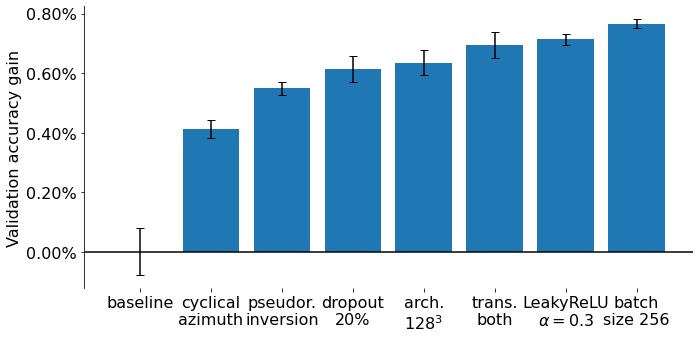

In [104]:
cols = ['baseline', 'phi_aug', 'eta_aug', 'drop_0.20', 'depth_3', 'trans_both', 'nonlinearity_VLReLU', 'batch_size_256']
accuracies = df_val_max.loc[cols].values.astype(float)
labels = ['baseline', 'cyclical\nazimuth', 'pseudor.\ninversion', 'dropout\n20%', 'arch.\n$128^3$', 'trans.\nboth', 'LeakyReLU\n$\\alpha=0.3$', 'batch\nsize 256']
plot_accuracy_gain(accuracies, labels, baseline=0, fn='master')

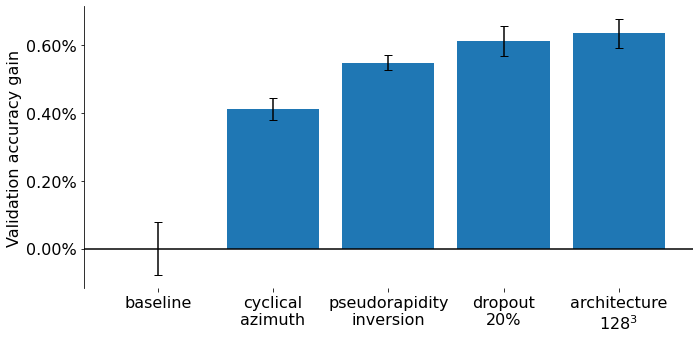

In [105]:
cols = ['baseline', 'phi_aug', 'eta_aug', 'drop_0.20', 'depth_3']
accuracies = df_val_max.loc[cols].values.astype(float)
labels = ['baseline', 'cyclical\nazimuth', 'pseudorapidity\ninversion', 'dropout\n20%', 'architecture\n$128^3$']
plot_accuracy_gain(accuracies, labels, baseline=0, fn='master_1')

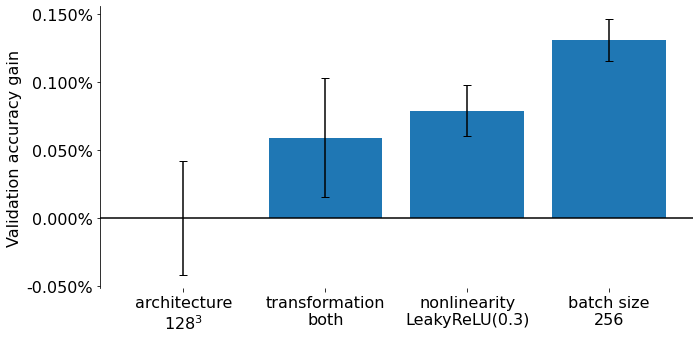

In [131]:
cols = ['depth_3', 'trans_both', 'nonlinearity_VLReLU', 'batch_size_256']
accuracies = df_val_max.loc[cols].values.astype(float)
labels = ['architecture\n$128^3$', 'transformation\nboth', 'nonlinearity\nLeakyReLU(0.3)', 'batch size\n256']
plot_accuracy_gain(accuracies, labels, baseline=0, fn='master_2')

### Sweeps: max. validation accuracy

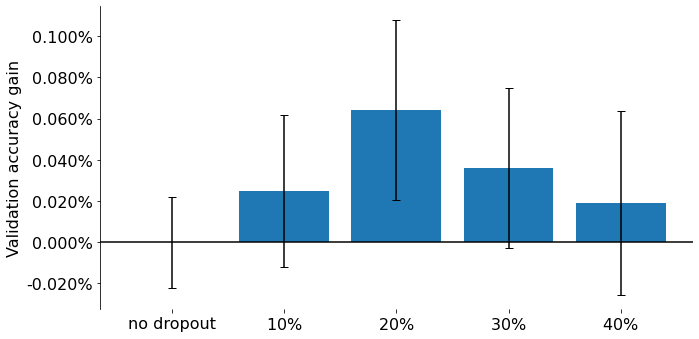

In [119]:
cols = ['eta_aug', 'drop_0.10', 'drop_0.20', 'drop_0.30', 'drop_0.40']
accuracies = df_val_max.loc[cols].values.astype(float)
labels = ['no dropout', '$10\%$', '$20\%$', '$30\%$', '$40\%$']
plot_accuracy_gain(accuracies, labels, baseline=0, fn='sweep_dropout')

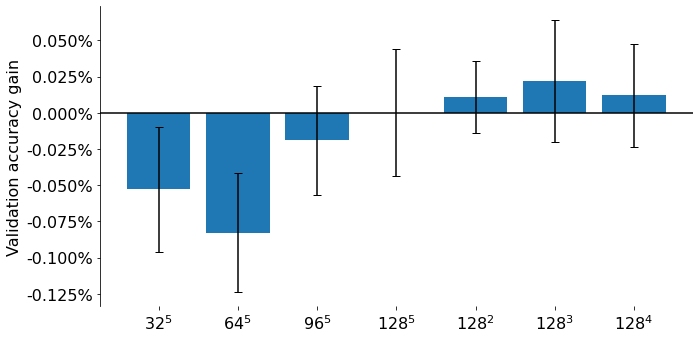

In [120]:
cols = ['width_32', 'width_64', 'width_96', 'drop_0.20', 'depth_2', 'depth_3', 'depth_4']
accuracies = df_val_max.loc[cols].values.astype(float)
labels = ['$32^5$', '$64^5$', '$96^5$', '$128^5$', '$128^2$', '$128^3$', '$128^4$']
plot_accuracy_gain(accuracies, labels, baseline=3, fn='sweep_architecture')

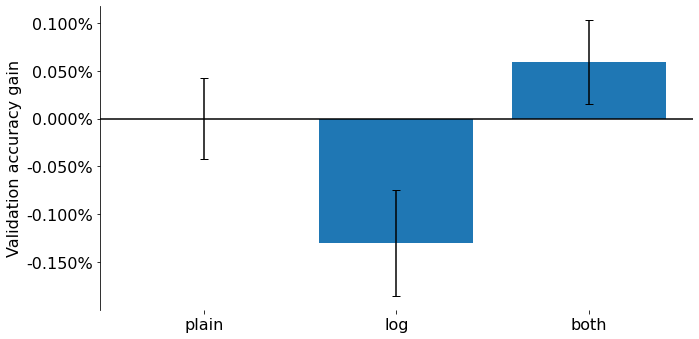

In [121]:
cols = ['depth_3', 'trans_log', 'trans_both']
accuracies = df_val_max.loc[cols].values.astype(float)
labels = ['plain', 'log', 'both']
plot_accuracy_gain(accuracies, labels, baseline=0, fn='sweep_transformation')

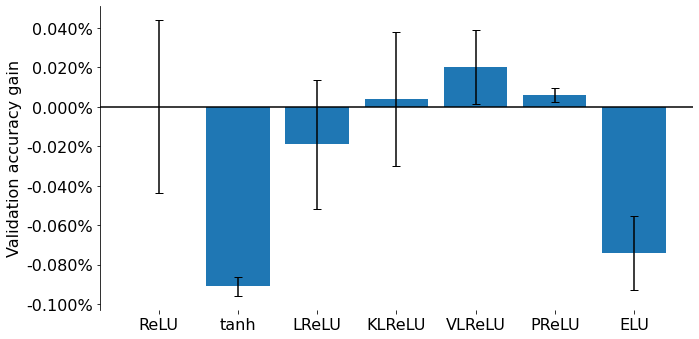

In [122]:
cols = ['trans_both']
[cols.append("nonlinearity_{}".format(s)) for s in ['tanh', 'LReLU', 'KindaLReLU', 'VLReLU', 'PReLU', 'ELU']]
accuracies = df_val_max.loc[cols].values.astype(float)
labels = ['ReLU', 'tanh', 'LReLU', 'KLReLU', 'VLReLU', 'PReLU', 'ELU']
plot_accuracy_gain(accuracies, labels, baseline=0, fn='sweep_nonlinearity')

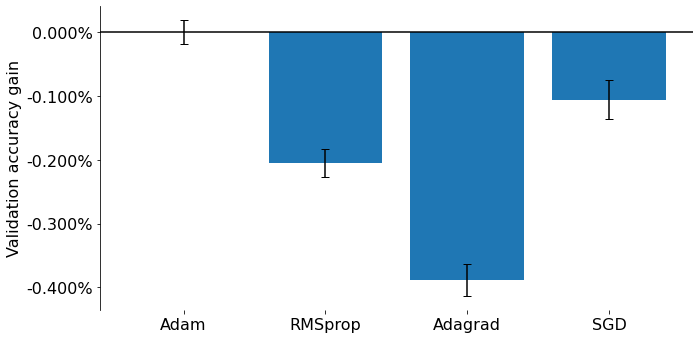

In [123]:

cols = ['nonlinearity_VLReLU', 'optimizer_RMSprop', 'optimizer_Adagrad', 'optimizer_SGD']
accuracies = df_val_max.loc[cols].values.astype(float)
labels = ['Adam', 'RMSprop', 'Adagrad', 'SGD']
plot_accuracy_gain(accuracies, labels, baseline=0, fn='sweep_optimizer')

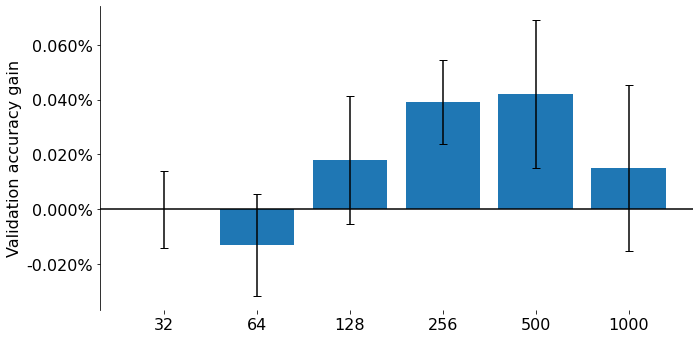

In [124]:
cols = ['batch_size_32', 'nonlinearity_VLReLU', 'batch_size_128', 'batch_size_256', 'batch_size_500', 'batch_size_1000']
accuracies = df_val_max.loc[cols].values.astype(float)
labels = ['32', '64', '128', '256', '500', '1000']
plot_accuracy_gain(accuracies, labels, baseline=0, fn='sweep_batch_size')

### Sweeps: final epoch validation accuracy

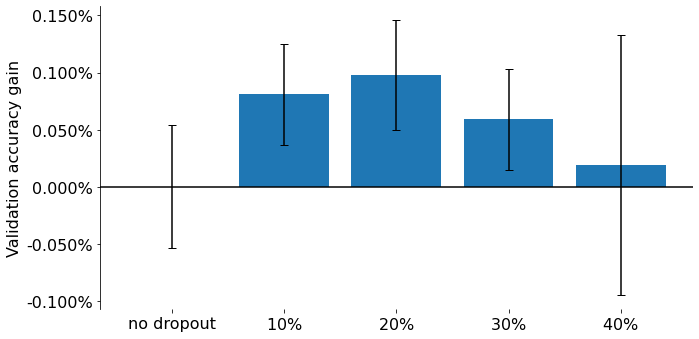

In [125]:
cols = ['eta_aug', 'drop_0.10', 'drop_0.20', 'drop_0.30', 'drop_0.40']
accuracies = df_val_final.loc[cols].values.astype(float)
labels = ['no dropout', '$10\%$', '$20\%$', '$30\%$', '$40\%$']
plot_accuracy_gain(accuracies, labels, baseline=0, fn='sweep_dropout_finalep')

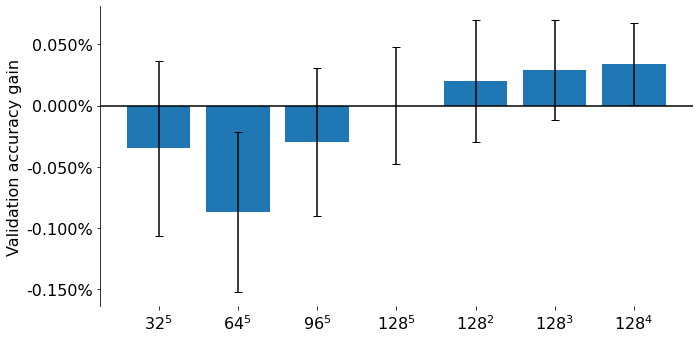

In [126]:
cols = ['width_32', 'width_64', 'width_96', 'drop_0.20', 'depth_2', 'depth_3', 'depth_4']
accuracies = df_val_final.loc[cols].values.astype(float)
labels = ['$32^5$', '$64^5$', '$96^5$', '$128^5$', '$128^2$', '$128^3$', '$128^4$']
plot_accuracy_gain(accuracies, labels, baseline=3, fn='sweep_architecture_finalep')

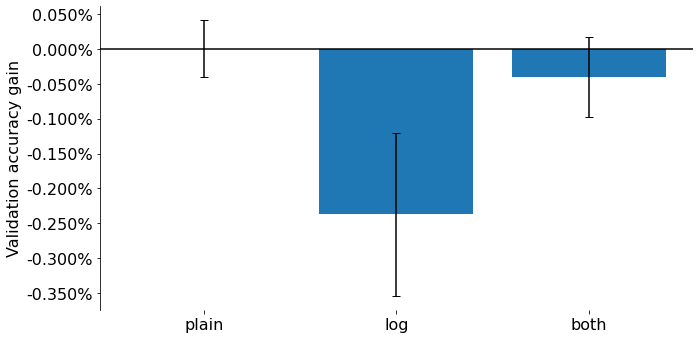

In [127]:
cols = ['depth_3', 'trans_log', 'trans_both']
accuracies = df_val_final.loc[cols].values.astype(float)
labels = ['plain', 'log', 'both']
plot_accuracy_gain(accuracies, labels, baseline=0, fn='sweep_transformation_finalep')

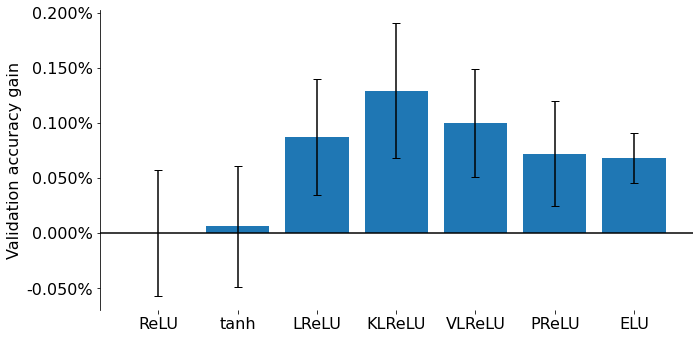

In [128]:
cols = ['trans_both']
[cols.append("nonlinearity_{}".format(s)) for s in ['tanh', 'LReLU', 'KindaLReLU', 'VLReLU', 'PReLU', 'ELU']]
accuracies = df_val_final.loc[cols].values.astype(float)
labels = ['ReLU', 'tanh', 'LReLU', 'KLReLU', 'VLReLU', 'PReLU', 'ELU']
plot_accuracy_gain(accuracies, labels, baseline=0, fn='sweep_nonlinearity_finalep')

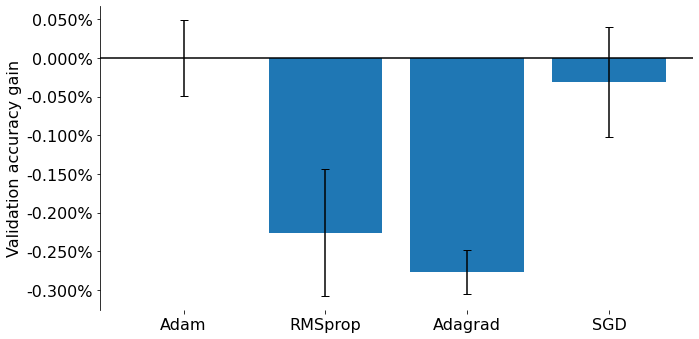

In [129]:
cols = ['nonlinearity_VLReLU', 'optimizer_RMSprop', 'optimizer_Adagrad', 'optimizer_SGD']
accuracies = df_val_final.loc[cols].values.astype(float)
labels = ['Adam', 'RMSprop', 'Adagrad', 'SGD']
plot_accuracy_gain(accuracies, labels, baseline=0, fn='sweep_optimizer_finalep')

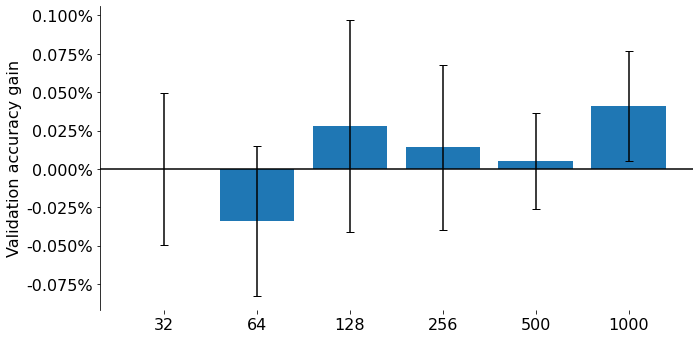

In [130]:
cols = ['batch_size_32', 'nonlinearity_VLReLU', 'batch_size_128', 'batch_size_256', 'batch_size_500', 'batch_size_1000']
accuracies = df_val_final.loc[cols].values.astype(float)
labels = ['32', '64', '128', '256', '500', '1000']
plot_accuracy_gain(accuracies, labels, baseline=0, fn='sweep_batch_size_finalep')